In [94]:
import numpy as np

def PL_copilot(distance: float, freq: float, h_t: float, h_r: float) -> float:
    """
    distance: distance between transmitter and receiver (m)
    freq: frequency (Hz)
    h_t: height of transmitter (m)
    h_r: height of receiver (m)
    """
    return 20 * np.log10(distance) + 20 * np.log10(freq) + 32.44 - 10 * np.log10((h_t - h_r) ** 2 + distance ** 2)

def PL_sBS(distance: float, Xa: float = 10):
    """
    Path loss for carrier frequency 2000MHz and height of 15m
    """
    return 128.1 + 37.6 * np.log10(distance) + Xa

def PL_mBS(distance: float, Xa: float = 10):
    """
    Path loss for carrier frequency 900MHz and height of 45m
    """
    return 95.5 + 34.01 * np.log10(distance) + Xa

def RSRP(bs_type: str, transit_power, antennae_gain, distance):
    if bs_type == "sBS":
        return transit_power + antennae_gain - PL_sBS(distance) 
    elif bs_type == "mBS":
        return transit_power + antennae_gain - PL_mBS(distance)
    else:
        raise ValueError("bs_type must be either sBS or mBS")

(0.0, 500.0)

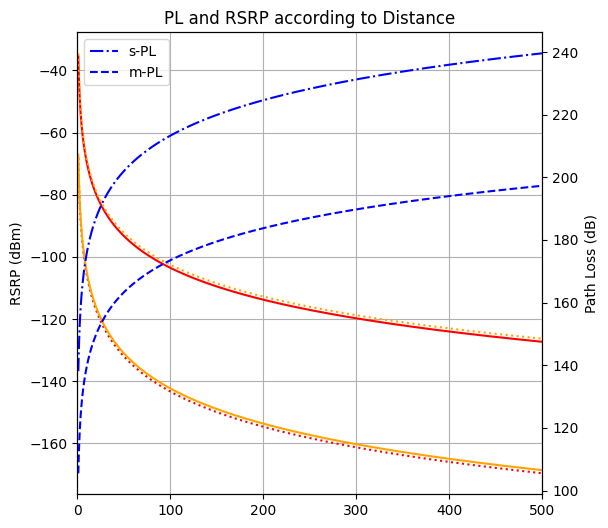

In [96]:
import matplotlib.pyplot as plt

# Propogation Loss per Distance

dist = np.linspace(1, 500, 1000)

# plt.figure(figsize=(6, 6))
fig, ax1 = plt.subplots()
fig.set_size_inches(6, 6)
# Add gridlines
plt.grid(True)
plt.title("PL and RSRP according to Distance")

ax2 = ax1.twinx()
plt.xlabel("Distance (m)")

ax1.set_ylabel("RSRP (dBm)")
TPTG = 70
ax1.plot(dist, -PL_sBS(dist) + TPTG, label='s-RSRP', linestyle='dotted', color='red')
ax1.plot(dist, -PL_mBS(dist) + TPTG, label='m-RSRP', linestyle='-', color='red')

ax1.plot(dist, RSRP('mBS', 46, 15, dist), label='m-RSRP', linestyle='dotted', color='orange')
ax1.plot(dist, RSRP('sBS', 46, 15, dist), label='s-RSRP', linestyle='-', color='orange')

ax2.set_ylabel("Path Loss (dB)")
ax2.plot(dist, PL_sBS(dist), label='s-PL', linestyle='-.', color='blue')
ax2.plot(dist, PL_mBS(dist), label='m-PL', linestyle='--', color='blue')

plt.legend()
plt.xlim(0, 500)

In [114]:
from matplotlib.patches import RegularPolygon

class BS:
    def __init__(self, id, x, y, freq, height, power, capacity, alpha, radius):
        self.id = id
        self.x = x
        self.y = y
        self.freq = freq
        self.height = height
        self.antenae_gain = 15
        self.power = power
        self.capacity = capacity
        self.alpha = alpha
        self.radius = radius

class MacroBS(BS):
    def __init__(self, id, x, y):
        super().__init__(id, x, y, 900, 45, 46, 200, 0.5, 500)
    
    def plot(self, ax):
        mBS_patch = RegularPolygon([self.x, self.y], numVertices=6, radius=500, orientation=np.pi/6, alpha=0.1, facecolor='blue', edgecolor='black')
        ax.add_patch(mBS_patch)
        ax.scatter(self.x, self.y, color='black', marker='s', s=100)

    def contains(self, x, y):
        x, y = map(abs, (x-self.x, y-self.y))
        return y < 3**0.5 * min(500 - x, 500 / 2)

POWER_BOOST = 45
class SmallBS(BS):
    def __init__(self, id, x, y, parent: MacroBS):
        super().__init__(id, x, y, 2000, 15, 30+POWER_BOOST, 50, 0.8, 200)
        self.parent = parent

    def plot(self, ax):
        sBS_patch = plt.Circle([self.x, self.y], radius=200, alpha=0.1, facecolor='red', edgecolor='black')
        ax.scatter(self.x, self.y, color='black', marker='^', s=100)
        ax.add_patch(sBS_patch)
        

class UE:
    def __init__(self, x, y, speed, bs=None, color='black'):
        self.x = x
        self.y = y
        self.bs = bs
        self.speed = speed
        self.angle = np.random.uniform(0, 2*np.pi)
        self.color = color
    
    def move(self, dt):
        # Change angle slightly
        self.angle += np.random.normal(-np.pi/12, np.pi/12)
        self.x += self.speed * np.cos(self.angle) * dt
        self.y += self.speed * np.sin(self.angle) * dt
    
    def move_back(self, dt):
        self.x -= self.speed * np.cos(self.angle) * dt
        self.y -= self.speed * np.sin(self.angle) * dt
        self.angle -= np.pi/2
    
    def measurement_report(self, cells: list):
        report = []
        for cell in cells:
            cell_dist = np.sqrt((self.x - cell.x)**2 + (self.y - cell.y)**2)
            is_mbs = isinstance(cell, MacroBS)
            power = RSRP('mBS' if is_mbs else 'sBS', cell.power, cell.antenae_gain, cell_dist)
            report.append([cell.id, power])
        return sorted(report, key=lambda x: x[1], reverse=True)

In [115]:
######################
# CREATE ENVIRONMENT #
######################
def create_environment():
    # HEXAGON MATH
    r = 500 # radius of hexagon
    a = r * np.sqrt(3) / 2 # Apothem of hexagon
    # Get 6 offsets from hexagon centre 0.5 radius away
    hr = 500 / 2 # half radius
    hex_offsets = np.array([[hr, 0], [hr*np.cos(np.pi/3), hr*np.sin(np.pi/3)], [-hr*np.cos(np.pi/3), hr*np.sin(np.pi/3)], [-hr, 0], [-hr*np.cos(np.pi/3), -hr*np.sin(np.pi/3)], [hr*np.cos(np.pi/3), -hr*np.sin(np.pi/3)]])

    mBS_locations = np.array([[500, a], [1250, 2*a], [500, 3*a]])
    mBS_cells = [MacroBS(i, mBS_loc[0], mBS_loc[1]) for i, mBS_loc in enumerate(mBS_locations)]

    sBS_cells = []
    for i, mBS in enumerate(mBS_locations):
        for j, location in enumerate(mBS + hex_offsets[[1,3,5]]):
            # print(location)
            sBS_cells.append(SmallBS(i*3+j+3,location[0], location[1], mBS_cells[i]))

    np.random.seed(0)
    ue_points = []
    ue_bs = []
    while len(ue_points) < 1000:
        x, y = np.random.randint(0, 1750), np.random.randint(0, 1750)
        for mBS in mBS_cells:
            if mBS.contains(x, y):
                ue_bs.append(mBS)
                ue_points.append([float(x), float(y)])
                break
        
    colours = {mBS_cells[0]: 'red', mBS_cells[1]: 'green', mBS_cells[2]: 'blue'}

    UEs = []
    for i in range(1000):
        if i < 400:
            UEs.append(UE(ue_points[i][0], ue_points[i][1], 0, bs=ue_bs[i], color=colours[ue_bs[i]]))
        elif i < 600:
            UEs.append(UE(ue_points[i][0], ue_points[i][1], 5/3.6, bs=ue_bs[i], color=colours[ue_bs[i]]))
        elif i < 800:
            UEs.append(UE(ue_points[i][0], ue_points[i][1], 25/3.6, bs=ue_bs[i], color=colours[ue_bs[i]]))
        else:
            UEs.append(UE(ue_points[i][0], ue_points[i][1], 60/3.6, bs=ue_bs[i], color=colours[ue_bs[i]]))
    return mBS_cells, sBS_cells, UEs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


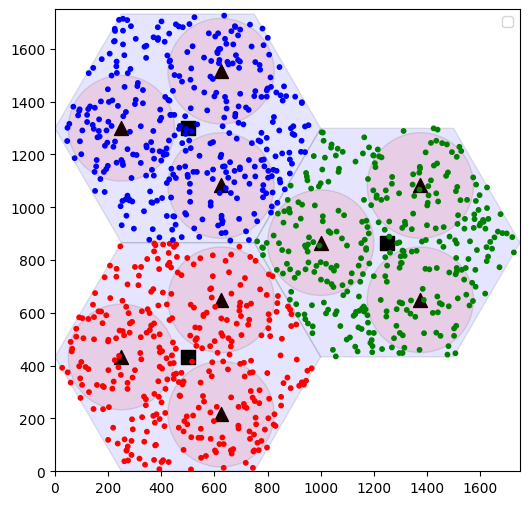

In [116]:
def plot_environment(mBS_cells, sBS_cells, UEs=None):
    plt.figure(figsize=(6, 6))

    ax = plt.gca()
    for mBS in mBS_cells:
        mBS.plot(ax)
    for sBS in sBS_cells:
        sBS.plot(ax)

    if UEs is not None:
        ue_array = np.array([[ue.x, ue.y] for ue in UEs])
        colours = ([ue.color for ue in UEs])
        # print(ue_array)
        plt.scatter(ue_array[:,0], ue_array[:,1], color=colours, s=10)

    plt.xlim(0, 1750)
    plt.ylim(0, 1750)
    plt.legend()

mBS_cells, sBS_cells, UEs = create_environment()
plot_environment(mBS_cells, sBS_cells, UEs)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


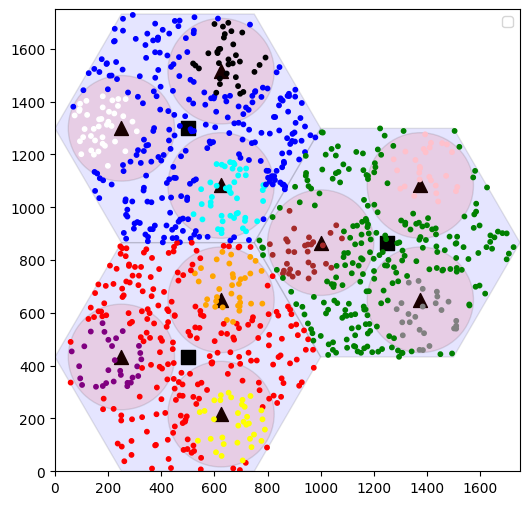

In [121]:
# BS colours
bs_colours = {
    0: 'red',
    1: 'green',
    2: 'blue',
    3: 'orange',
    4: 'purple',
    5: 'yellow',
    6: 'pink',
    7: 'brown',
    8: 'grey',
    9: 'black',
    10: 'white',
    11: 'cyan'
}

for ue in UEs:
    closest_cell = ue.measurement_report(mBS_cells + sBS_cells)[0][0]
    ue.color = bs_colours[closest_cell]

plot_environment(mBS_cells, sBS_cells, UEs)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


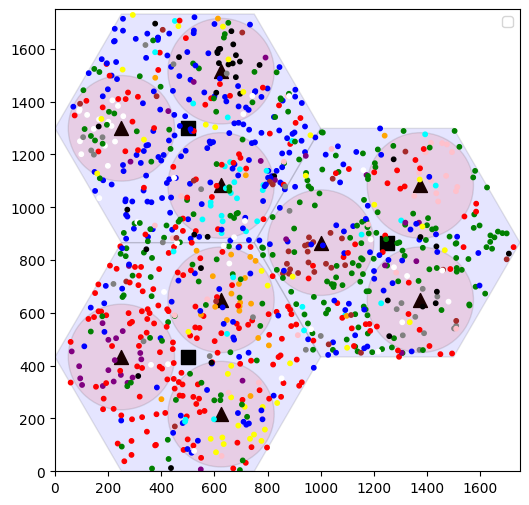

In [120]:
def move_UEs(UEs, dt=60):
    for ue in UEs:
        ue.move(dt)
        # if ue.bs is None: continue
        old_bs = ue.bs
        if not ue.bs.contains(ue.x, ue.y):
            ue.bs = None
            for bs in mBS_cells:
                if bs.contains(ue.x, ue.y):
                    ue.bs = bs
                    break
            if ue.bs is None:
                ue.move_back(dt)
                ue.bs = old_bs

for i in range(100):
    move_UEs(UEs)
plot_environment(mBS_cells, sBS_cells, UEs)

In [100]:
ue = UEs[0]
print(ue.bs.id)
print(ue.x, ue.y)
report = ue.measurement_report(mBS_cells + sBS_cells)
print(report)

for ue in UEs:
    closest_cell = ue.measurement_report(mBS_cells + sBS_cells)[0][0]
    if ue.bs.id != closest_cell:
        print(ue.bs.id, closest_cell)

0
684.0 559.0
[[0, -114.36581858425595], [1, -130.0281531169896], [2, -132.52632542647405], [3, -143.56421896389628], [5, -162.64170248878065], [7, -166.51574648961756], [4, -166.93019929960224], [11, -169.43530047166024], [8, -174.00329501696103], [10, -177.39744044263114], [6, -177.56818736011235], [9, -179.20551750947467]]
2 11
0 4
1 6
1 7
1 8


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


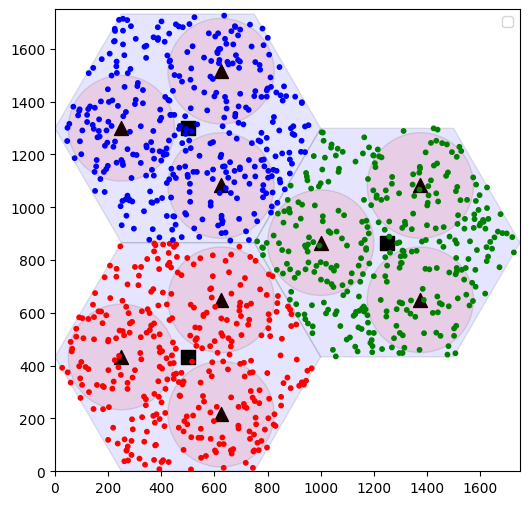

In [1]:
from src.environment import Environment

env = Environment()

env.plot_environment()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


HANDOVER: UE15: 0->3
HANDOVER: UE17: 0->5
HANDOVER: UE25: 2->10
HANDOVER: UE29: 2->9
HANDOVER: UE33: 2->11
HANDOVER: UE34: 1->7
HANDOVER: UE36: 1->7
HANDOVER: UE39: 1->6
HANDOVER: UE45: 0->4
HANDOVER: UE50: 0->3
HANDOVER: UE58: 1->6
HANDOVER: UE60: 1->8
HANDOVER: UE63: 1->6
HANDOVER: UE72: 2->9
HANDOVER: UE75: 1->7
HANDOVER: UE84: 1->6
HANDOVER: UE107: 2->10
HANDOVER: UE108: 0->4
HANDOVER: UE115: 0->4
HANDOVER: UE117: 2->9
HANDOVER: UE121: 1->7
HANDOVER: UE125: 1->7
HANDOVER: UE126: 0->3
HANDOVER: UE131: 2->9
HANDOVER: UE137: 2->11
HANDOVER: UE142: 1->7
HANDOVER: UE143: 1->7
HANDOVER: UE149: 2->10
HANDOVER: UE151: 1->7
HANDOVER: UE155: 0->5
HANDOVER: UE159: 1->6
HANDOVER: UE169: 2->10
HANDOVER: UE171: 0->3
HANDOVER: UE172: 2->10
HANDOVER: UE180: 0->4
HANDOVER: UE187: 1->6
HANDOVER: UE188: 1->8
HANDOVER: UE197: 0->5
HANDOVER: UE208: 2->10
HANDOVER: UE227: 2->9
HANDOVER: UE233: 2->11
HANDOVER: UE243: 0->3
HANDOVER: UE252: 2->9
HANDOVER: UE253: 1->8
HANDOVER: UE254: 2->11
HANDOVER: UE264:

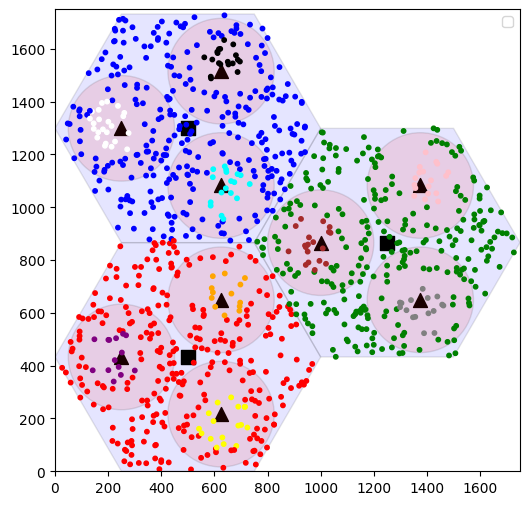

In [2]:
env.move_UEs(1)
env.plot_environment()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


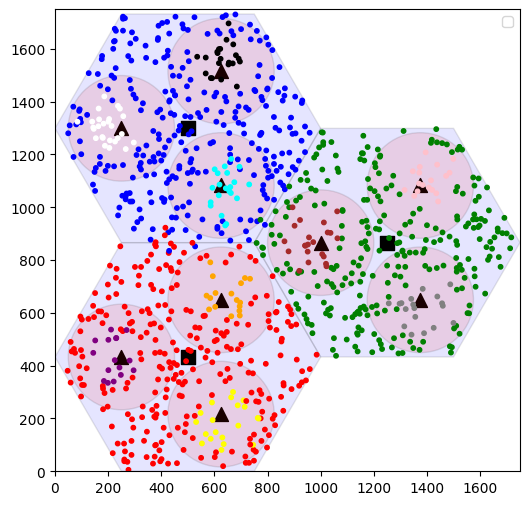

In [15]:
env.move_UEs(0.07)
env.plot_environment()